In [1]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [4]:
# importing the libraries and packages
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize    
from nltk.tokenize import wordpunct_tokenize
from nltk.stem import WordNetLemmatizer
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, matthews_corrcoef,PrecisionRecallDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB,BernoulliNB
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.model_selection import cross_val_score
import pandas as pd
import numpy as np
import seaborn as sns
import os
import re

In [10]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

## Part 1:  Text Classification



### Part 1A: Statistical Method

For the Statistical Method I have chosen GradientBoostingClassifier()algorithm. The goal here is to build all the 24 combinations for this particular algorithm and calculating the values of accuracy, precision, recall, F1-score and P-R curves for all the models.

The GradientBoostingClassifier algorithm works by training a series of decision tree models, where each new tree is trained to correct the errors of the previous ones. The model combines the output of all the trees to make the final prediction. This iterative process of training new trees and combining them is called gradient boosting.

In [ ]:
# training data
df_train = pd.read_csv(os.getcwd()+'/train.csv', delimiter=',')
display(df_train.head())
print(df_train.shape)

,title,abstract,InformationTheory,ComputationalLinguistics,ComputerVision
0,Objective-Dependent Uncertainty Driven Retinal...,From diagnosing neovascular diseases to dete...,0,0,1
1,SMARTies: Sentiment Models for Arabic Target E...,We consider entity-level sentiment analysis ...,0,1,0
2,State-Aware Tracker for Real-Time Video Object...,In this work we address the task of semi-sup...,0,0,1
3,On the Performance of Optimized Dense Device-t...,We consider a D2D wireless network where $n$...,1,0,0
4,Design of Minimum Correlated Maximal Clique Se...,This paper proposes an algorithm to search a...,1,0,0


(125000, 5)


In [ ]:
# test data
df_test = pd.read_csv(os.getcwd() + '/test.csv', delimiter=',')
display(df_test.head())
print(df_test.shape)

,title,abstract,InformationTheory,ComputationalLinguistics,ComputerVision
0,Joint stereo 3D object detection and implicit ...,We present the first learning-based framewor...,0,0,1
1,The Past Mistake is the Future Wisdom: Error-d...,Chinese Spell Checking (CSC) aims to detect ...,0,1,0
2,Label Relation Graphs Enhanced Hierarchical Re...,Hierarchical multi-granularity classificatio...,0,0,1
3,Learning Aligned Cross-Modal Representation fo...,Learning a common latent embedding by aligni...,0,0,1
4,LTC-SUM: Lightweight Client-driven Personalize...,This paper proposes a novel lightweight thum...,0,0,1


(18066, 5)


In [ ]:
# finding distribution of 0's and 1's for all three labels
print('Proportion of InformationTheory "0" in Training {:.4f}\n'.format(df_train[df_train['InformationTheory']==0].shape[0]/df_train.shape[0]))
print('Proportion of ComputationalLinguistics "0" in Training {:.4f}\n'.format(df_train[df_train['ComputationalLinguistics']==0].shape[0]/df_train.shape[0]))
print('Proportion of ComputerVision "0" in Training {:.4f}\n'.format(df_train[df_train['ComputerVision']==0].shape[0]/df_train.shape[0]))

Proportion of InformationTheory "0" in Training 0.7600

Proportion of ComputationalLinguistics "0" in Training 0.7600

Proportion of ComputerVision "0" in Training 0.4800



In [ ]:
# Lemmitization and Tokenisation
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl=WordNetLemmatizer()
    def __call__(self,doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

In [ ]:
# function for text pre-processing and vectorization
def text_prepros(prepros):
    """
    Performs pre-processing of documents and returns a vector object

    Parameters:
    ----------
    prepros: processing type to apply

    Returns:
    -------
    vec: preprocessed TfidfVectorizer corpus

    """
    if prepros == '1':
        vec = TfidfVectorizer(analyzer='word',input='content',
                lowercase=True,        #The vectorizer will convert all text to lowercase.
                token_pattern='(?u)\\b\\w\\w+\\b',
                stop_words = list(set(stopwords.words('english'))),
                min_df = 5,            # ignore terms with document frequency lower than 5             
                max_df = 0.75,         # ignore terms present in 75% of enteries            
                ngram_range = (1,2),
                tokenizer=LemmaTokenizer())   
    elif prepros == '2':

        vec = TfidfVectorizer(analyzer='word',input='content',
                    lowercase=True,
                    token_pattern='(?u)\\b\\D+\\b',   #vectorizer will consider only non-digit tokens
                    min_df = 5,                         
                    max_df = 0.75,                     
                    ngram_range = (1,2),
                    tokenizer=LemmaTokenizer())
    else:
        print('Invalid Choice: Please select 1 or 2')

    return vec
        

In [ ]:

def classifier_builder(df_train,df_test,df_size,pp,training_cols,classifying_cols):
    
    """
      Performs splitting the training data into training and validation data,
      applies pre-processing on test data using the function created in the 
      previous step, uses grid search alogrithm on validation data for
      hyper-parameters tuning, trains our model using GradientBoostingClassifier()
      algorithm, predicts the values of our target label, prints the values of accuracy,
      precesion, recall, F-1 score, confusion matrix and the P-R curve.
      Parameters:
      ----------
      df_train: training data
      df_test: test data
      df_size: size of training data-set
      pp: pre-processing
      training_cols: feature column
      classifying_cols: label column  
      Output:
      -------
      prints accuracy,precesion, recall, F-1 score, confusion matrix and the P-R curve.

    """
    
    # setting size of training data
    if df_size == 1000:
        df_train = df_train.head(1000)
    else:
        df_train = df_train 
    
    train_size = int(0.9 * len(df_train)) 
    
    # creating our traning and validation datasets
    df_train_req = df_train.iloc[:train_size]
    df_train_val = df_train.iloc[train_size:]
    
    # vectorization
    vec_notation = text_prepros(pp)
    
    # lists to store feature labels for each dataset
    trainDocs = df_train_req[str(training_cols)].to_list()
    testDocs = df_test[str(training_cols)].to_list()
    valDocs = df_train_val[str(training_cols)].to_list()
    
    
    
    x_train = vec_notation.fit_transform(trainDocs)
    x_test = vec_notation.transform(testDocs)
    x_val = vec_notation.fit_transform(valDocs)
    
    # lists to store target label for each dataset
    trainLabels = df_train_req[str(classifying_cols)].to_list()
    testLabels = df_test[str(classifying_cols)].to_list()
    valLabels = df_train_val[str(classifying_cols)].to_list()
    
    y_train = np.asarray(trainLabels)
    y_test = np.asarray(testLabels)
    y_val = np.asarray(valLabels)
    
    # intialising our algorithm for grid-search
    gb_val = GradientBoostingClassifier() 
    
    # parameters for grid search
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.1, 0.01, 0.001]
    }
    
    # finding the best values of hyper-parameters through grid-search
    # Grid Search algorithm has been implemented with the help of chatGPT
    grid_search = GridSearchCV(gb_val, param_grid, cv=5, n_jobs=-1,scoring='f1_macro')
    grid_search.fit(x_val,y_val)
    print('#'*40)
    print('Best hyperparmeters through cross validation on last 10% of Data ')
    print("Best hyperparameters found: ", grid_search.best_params_)
    print('#'*40)
    
    # best value for 'n_estimators'
    n_e = grid_search.best_params_['n_estimators']
    # best value for 'max_depth' 
    m_d = grid_search.best_params_['max_depth']
    # best value for 'learning_rate'
    l_r = grid_search.best_params_['learning_rate']
    
    # fitting the GradientBoosting classifier algorithm on our training dataset
    gb_main = GradientBoostingClassifier(n_estimators = n_e,max_depth = m_d, learning_rate=l_r ) 
    gb_main.fit(x_train, y_train)               

    y_predict = gb_main.predict(x_test)  
    
    
    print('#'*40)
    print('Train Size: '+ str(train_size))
    print('Pre-Procesing: '+str(pp))
    print('Training Column: '+str(training_cols))
    print('Classifying Column: '+str(classifying_cols))
    print('#'*40)
    # producing confusion matrix
    print('-'*20)
    print('CONFUSION MATRIX:')
    print(confusion_matrix(y_test, y_predict))

    # recall score
    recall=recall_score(y_test, y_predict, average='macro')

    # precision score
    precision=precision_score(y_test, y_predict, average='macro')

    # f1 score
    f1score=f1_score(y_test, y_predict,average='macro')

    # accuracy score
    accuracy=accuracy_score(y_test, y_predict)
    

    print('Accuracy: '+ str(accuracy))
    print('Macro Precision: '+ str(precision))
    print('Macro Recall: '+ str(recall))
    print('Macro F1 score:'+ str(f1score))

    # precision-recall curve
    p_r_curve = PrecisionRecallDisplay.from_estimator(gb_main, x_test, y_test)
    plt.show()
    
    

In [ ]:
pip install combu


[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import warnings
warnings.filterwarnings('ignore')

Executing our function classifier_builder with different combinations of our parameters with the help of a library called combu

########################################
Best hyperparmeters through cross validation on last 10% of Data 
Best hyperparameters found:  {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 50}
########################################
########################################
Train Size: 900
Pre-Procesing: 1
Training Column: title
Classifying Column: InformationTheory
########################################
--------------------
CONFUSION MATRIX:
[[9532   55]
 [5679 2800]]
Accuracy: 0.6826082143252519
Macro Precision: 0.8036936584168453
Macro Recall: 0.6622453428741719
Macro F1 score:0.6314301290798098


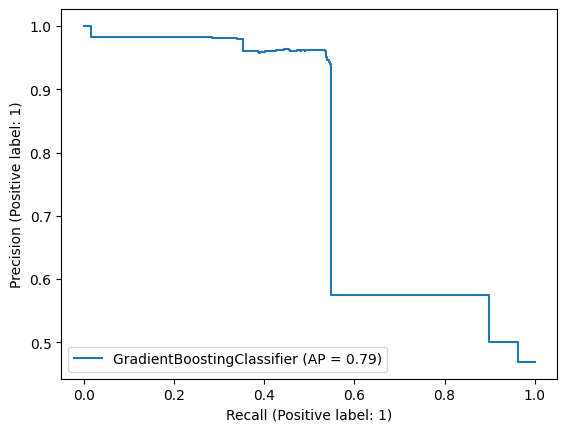

(None, {'df_train':                                                     title   
0       Objective-Dependent Uncertainty Driven Retinal...  \
1       SMARTies: Sentiment Models for Arabic Target E...   
2       State-Aware Tracker for Real-Time Video Object...   
3       On the Performance of Optimized Dense Device-t...   
4       Design of Minimum Correlated Maximal Clique Se...   
...                                                   ...   
124995  Domain Adaptation for Ear Recognition Using De...   
124996                      DeepHashing using TripletLoss   
124997  Appearance Based Deep Domain Adaptation for th...   
124998  The Importance of Automatic Syntactic Features...   
124999  Promising Accurate Prefix Boosting for sequenc...   

                                                 abstract  InformationTheory   
0         From diagnosing neovascular diseases to dete...                  0  \
1         We consider entity-level sentiment analysis ...                  0   
2      

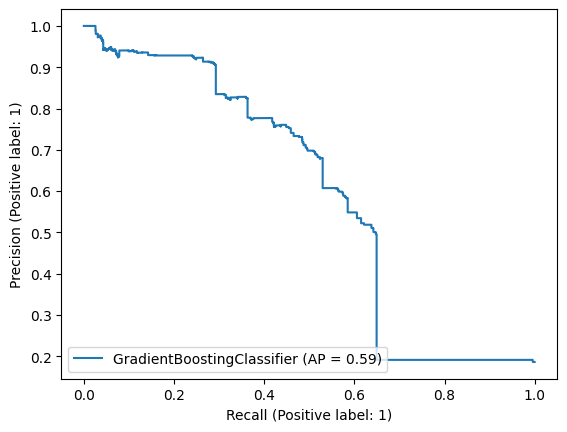

(None, {'df_train':                                                     title   
0       Objective-Dependent Uncertainty Driven Retinal...  \
1       SMARTies: Sentiment Models for Arabic Target E...   
2       State-Aware Tracker for Real-Time Video Object...   
3       On the Performance of Optimized Dense Device-t...   
4       Design of Minimum Correlated Maximal Clique Se...   
...                                                   ...   
124995  Domain Adaptation for Ear Recognition Using De...   
124996                      DeepHashing using TripletLoss   
124997  Appearance Based Deep Domain Adaptation for th...   
124998  The Importance of Automatic Syntactic Features...   
124999  Promising Accurate Prefix Boosting for sequenc...   

                                                 abstract  InformationTheory   
0         From diagnosing neovascular diseases to dete...                  0  \
1         We consider entity-level sentiment analysis ...                  0   
2      

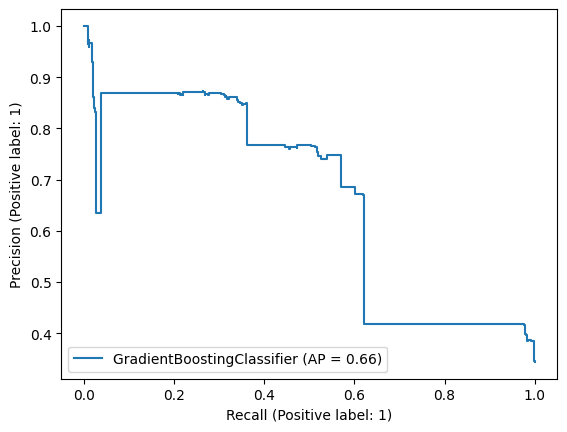

(None, {'df_train':                                                     title   
0       Objective-Dependent Uncertainty Driven Retinal...  \
1       SMARTies: Sentiment Models for Arabic Target E...   
2       State-Aware Tracker for Real-Time Video Object...   
3       On the Performance of Optimized Dense Device-t...   
4       Design of Minimum Correlated Maximal Clique Se...   
...                                                   ...   
124995  Domain Adaptation for Ear Recognition Using De...   
124996                      DeepHashing using TripletLoss   
124997  Appearance Based Deep Domain Adaptation for th...   
124998  The Importance of Automatic Syntactic Features...   
124999  Promising Accurate Prefix Boosting for sequenc...   

                                                 abstract  InformationTheory   
0         From diagnosing neovascular diseases to dete...                  0  \
1         We consider entity-level sentiment analysis ...                  0   
2      

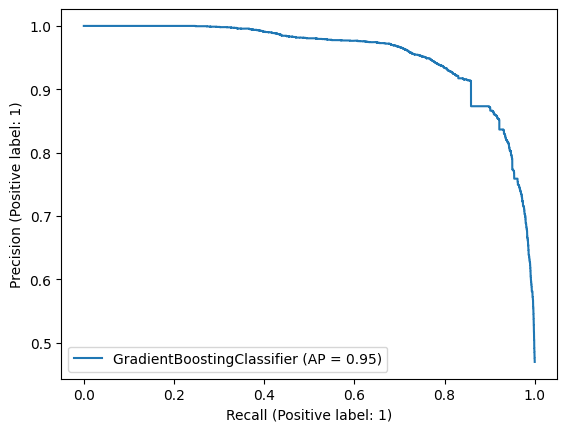

(None, {'df_train':                                                     title   
0       Objective-Dependent Uncertainty Driven Retinal...  \
1       SMARTies: Sentiment Models for Arabic Target E...   
2       State-Aware Tracker for Real-Time Video Object...   
3       On the Performance of Optimized Dense Device-t...   
4       Design of Minimum Correlated Maximal Clique Se...   
...                                                   ...   
124995  Domain Adaptation for Ear Recognition Using De...   
124996                      DeepHashing using TripletLoss   
124997  Appearance Based Deep Domain Adaptation for th...   
124998  The Importance of Automatic Syntactic Features...   
124999  Promising Accurate Prefix Boosting for sequenc...   

                                                 abstract  InformationTheory   
0         From diagnosing neovascular diseases to dete...                  0  \
1         We consider entity-level sentiment analysis ...                  0   
2      

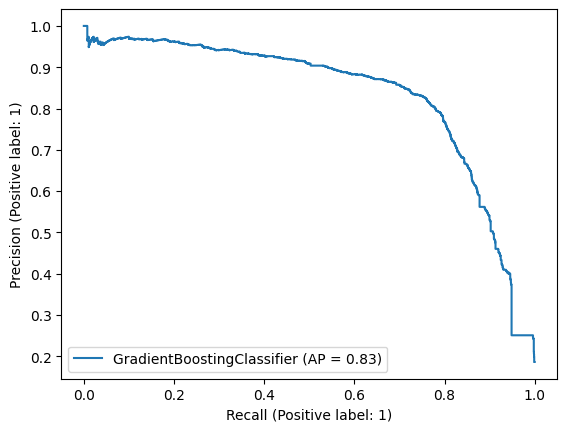

(None, {'df_train':                                                     title   
0       Objective-Dependent Uncertainty Driven Retinal...  \
1       SMARTies: Sentiment Models for Arabic Target E...   
2       State-Aware Tracker for Real-Time Video Object...   
3       On the Performance of Optimized Dense Device-t...   
4       Design of Minimum Correlated Maximal Clique Se...   
...                                                   ...   
124995  Domain Adaptation for Ear Recognition Using De...   
124996                      DeepHashing using TripletLoss   
124997  Appearance Based Deep Domain Adaptation for th...   
124998  The Importance of Automatic Syntactic Features...   
124999  Promising Accurate Prefix Boosting for sequenc...   

                                                 abstract  InformationTheory   
0         From diagnosing neovascular diseases to dete...                  0  \
1         We consider entity-level sentiment analysis ...                  0   
2      

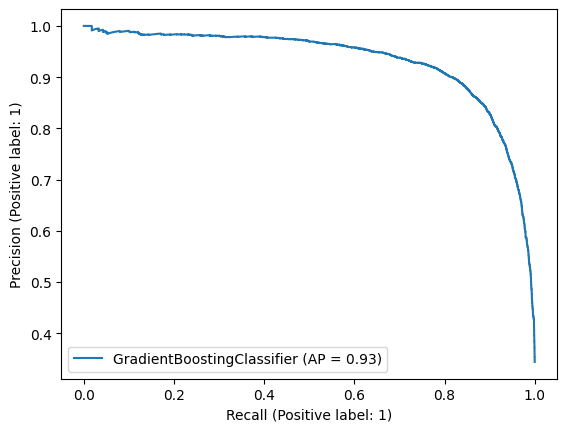

(None, {'df_train':                                                     title   
0       Objective-Dependent Uncertainty Driven Retinal...  \
1       SMARTies: Sentiment Models for Arabic Target E...   
2       State-Aware Tracker for Real-Time Video Object...   
3       On the Performance of Optimized Dense Device-t...   
4       Design of Minimum Correlated Maximal Clique Se...   
...                                                   ...   
124995  Domain Adaptation for Ear Recognition Using De...   
124996                      DeepHashing using TripletLoss   
124997  Appearance Based Deep Domain Adaptation for th...   
124998  The Importance of Automatic Syntactic Features...   
124999  Promising Accurate Prefix Boosting for sequenc...   

                                                 abstract  InformationTheory   
0         From diagnosing neovascular diseases to dete...                  0  \
1         We consider entity-level sentiment analysis ...                  0   
2      

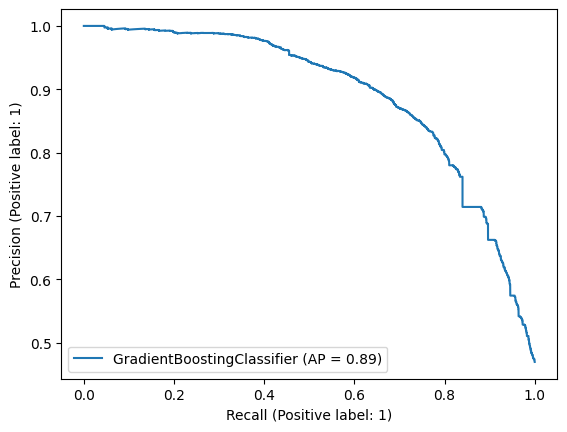

(None, {'df_train':                                                     title   
0       Objective-Dependent Uncertainty Driven Retinal...  \
1       SMARTies: Sentiment Models for Arabic Target E...   
2       State-Aware Tracker for Real-Time Video Object...   
3       On the Performance of Optimized Dense Device-t...   
4       Design of Minimum Correlated Maximal Clique Se...   
...                                                   ...   
124995  Domain Adaptation for Ear Recognition Using De...   
124996                      DeepHashing using TripletLoss   
124997  Appearance Based Deep Domain Adaptation for th...   
124998  The Importance of Automatic Syntactic Features...   
124999  Promising Accurate Prefix Boosting for sequenc...   

                                                 abstract  InformationTheory   
0         From diagnosing neovascular diseases to dete...                  0  \
1         We consider entity-level sentiment analysis ...                  0   
2      

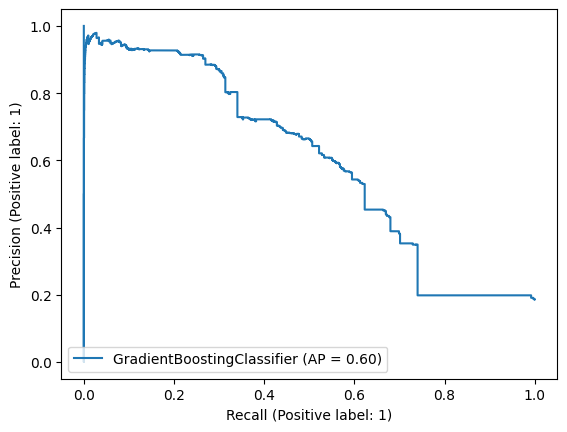

(None, {'df_train':                                                     title   
0       Objective-Dependent Uncertainty Driven Retinal...  \
1       SMARTies: Sentiment Models for Arabic Target E...   
2       State-Aware Tracker for Real-Time Video Object...   
3       On the Performance of Optimized Dense Device-t...   
4       Design of Minimum Correlated Maximal Clique Se...   
...                                                   ...   
124995  Domain Adaptation for Ear Recognition Using De...   
124996                      DeepHashing using TripletLoss   
124997  Appearance Based Deep Domain Adaptation for th...   
124998  The Importance of Automatic Syntactic Features...   
124999  Promising Accurate Prefix Boosting for sequenc...   

                                                 abstract  InformationTheory   
0         From diagnosing neovascular diseases to dete...                  0  \
1         We consider entity-level sentiment analysis ...                  0   
2      

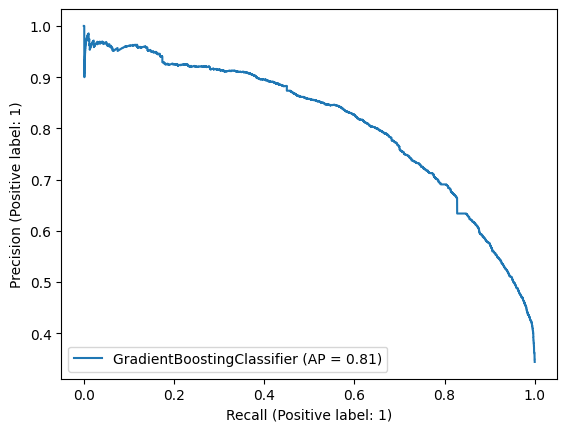

(None, {'df_train':                                                     title   
0       Objective-Dependent Uncertainty Driven Retinal...  \
1       SMARTies: Sentiment Models for Arabic Target E...   
2       State-Aware Tracker for Real-Time Video Object...   
3       On the Performance of Optimized Dense Device-t...   
4       Design of Minimum Correlated Maximal Clique Se...   
...                                                   ...   
124995  Domain Adaptation for Ear Recognition Using De...   
124996                      DeepHashing using TripletLoss   
124997  Appearance Based Deep Domain Adaptation for th...   
124998  The Importance of Automatic Syntactic Features...   
124999  Promising Accurate Prefix Boosting for sequenc...   

                                                 abstract  InformationTheory   
0         From diagnosing neovascular diseases to dete...                  0  \
1         We consider entity-level sentiment analysis ...                  0   
2      

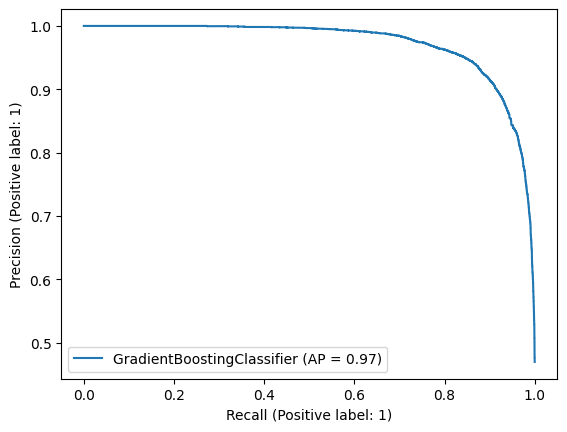

(None, {'df_train':                                                     title   
0       Objective-Dependent Uncertainty Driven Retinal...  \
1       SMARTies: Sentiment Models for Arabic Target E...   
2       State-Aware Tracker for Real-Time Video Object...   
3       On the Performance of Optimized Dense Device-t...   
4       Design of Minimum Correlated Maximal Clique Se...   
...                                                   ...   
124995  Domain Adaptation for Ear Recognition Using De...   
124996                      DeepHashing using TripletLoss   
124997  Appearance Based Deep Domain Adaptation for th...   
124998  The Importance of Automatic Syntactic Features...   
124999  Promising Accurate Prefix Boosting for sequenc...   

                                                 abstract  InformationTheory   
0         From diagnosing neovascular diseases to dete...                  0  \
1         We consider entity-level sentiment analysis ...                  0   
2      

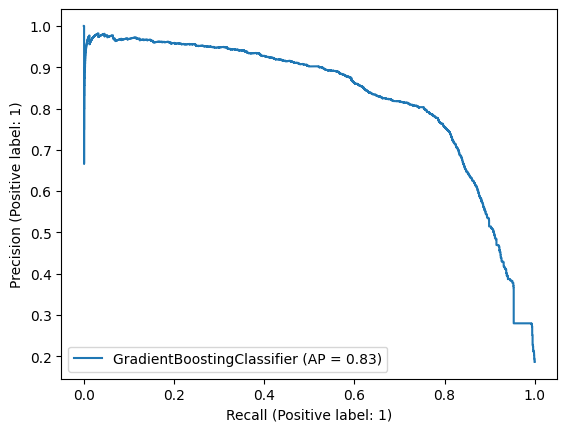

(None, {'df_train':                                                     title   
0       Objective-Dependent Uncertainty Driven Retinal...  \
1       SMARTies: Sentiment Models for Arabic Target E...   
2       State-Aware Tracker for Real-Time Video Object...   
3       On the Performance of Optimized Dense Device-t...   
4       Design of Minimum Correlated Maximal Clique Se...   
...                                                   ...   
124995  Domain Adaptation for Ear Recognition Using De...   
124996                      DeepHashing using TripletLoss   
124997  Appearance Based Deep Domain Adaptation for th...   
124998  The Importance of Automatic Syntactic Features...   
124999  Promising Accurate Prefix Boosting for sequenc...   

                                                 abstract  InformationTheory   
0         From diagnosing neovascular diseases to dete...                  0  \
1         We consider entity-level sentiment analysis ...                  0   
2      

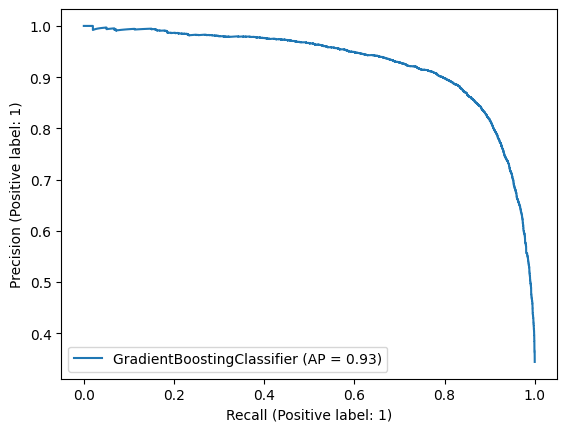

(None, {'df_train':                                                     title   
0       Objective-Dependent Uncertainty Driven Retinal...  \
1       SMARTies: Sentiment Models for Arabic Target E...   
2       State-Aware Tracker for Real-Time Video Object...   
3       On the Performance of Optimized Dense Device-t...   
4       Design of Minimum Correlated Maximal Clique Se...   
...                                                   ...   
124995  Domain Adaptation for Ear Recognition Using De...   
124996                      DeepHashing using TripletLoss   
124997  Appearance Based Deep Domain Adaptation for th...   
124998  The Importance of Automatic Syntactic Features...   
124999  Promising Accurate Prefix Boosting for sequenc...   

                                                 abstract  InformationTheory   
0         From diagnosing neovascular diseases to dete...                  0  \
1         We consider entity-level sentiment analysis ...                  0   
2      

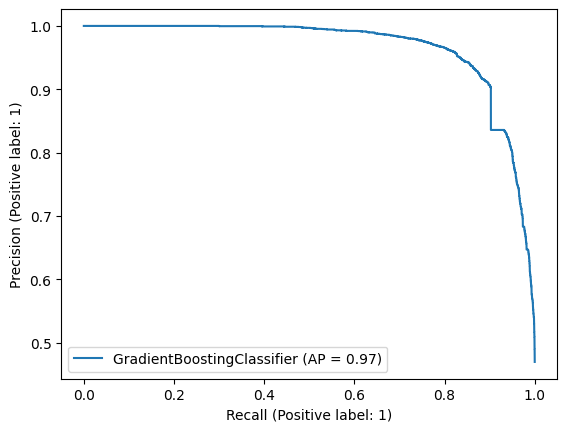

(None, {'df_train':                                                     title   
0       Objective-Dependent Uncertainty Driven Retinal...  \
1       SMARTies: Sentiment Models for Arabic Target E...   
2       State-Aware Tracker for Real-Time Video Object...   
3       On the Performance of Optimized Dense Device-t...   
4       Design of Minimum Correlated Maximal Clique Se...   
...                                                   ...   
124995  Domain Adaptation for Ear Recognition Using De...   
124996                      DeepHashing using TripletLoss   
124997  Appearance Based Deep Domain Adaptation for th...   
124998  The Importance of Automatic Syntactic Features...   
124999  Promising Accurate Prefix Boosting for sequenc...   

                                                 abstract  InformationTheory   
0         From diagnosing neovascular diseases to dete...                  0  \
1         We consider entity-level sentiment analysis ...                  0   
2      

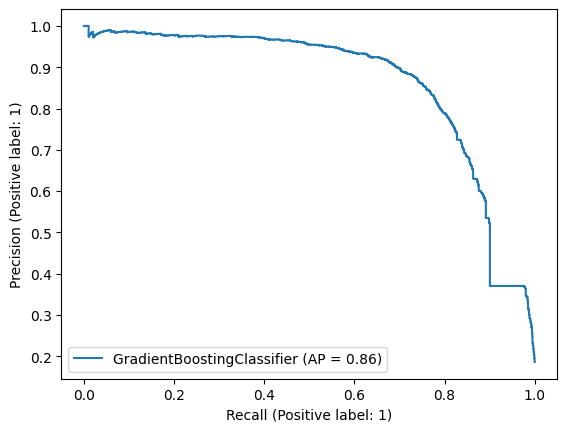

(None, {'df_train':                                                     title   
0       Objective-Dependent Uncertainty Driven Retinal...  \
1       SMARTies: Sentiment Models for Arabic Target E...   
2       State-Aware Tracker for Real-Time Video Object...   
3       On the Performance of Optimized Dense Device-t...   
4       Design of Minimum Correlated Maximal Clique Se...   
...                                                   ...   
124995  Domain Adaptation for Ear Recognition Using De...   
124996                      DeepHashing using TripletLoss   
124997  Appearance Based Deep Domain Adaptation for th...   
124998  The Importance of Automatic Syntactic Features...   
124999  Promising Accurate Prefix Boosting for sequenc...   

                                                 abstract  InformationTheory   
0         From diagnosing neovascular diseases to dete...                  0  \
1         We consider entity-level sentiment analysis ...                  0   
2      

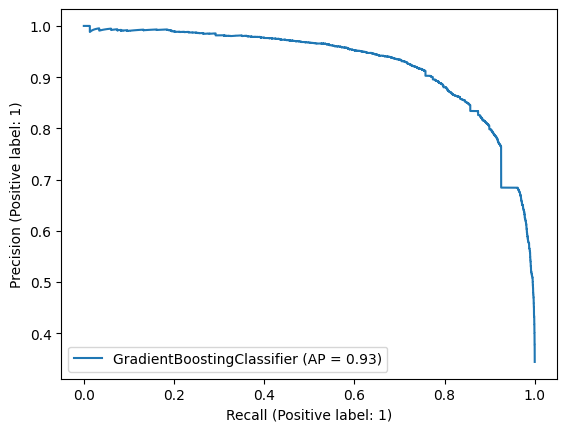

(None, {'df_train':                                                     title   
0       Objective-Dependent Uncertainty Driven Retinal...  \
1       SMARTies: Sentiment Models for Arabic Target E...   
2       State-Aware Tracker for Real-Time Video Object...   
3       On the Performance of Optimized Dense Device-t...   
4       Design of Minimum Correlated Maximal Clique Se...   
...                                                   ...   
124995  Domain Adaptation for Ear Recognition Using De...   
124996                      DeepHashing using TripletLoss   
124997  Appearance Based Deep Domain Adaptation for th...   
124998  The Importance of Automatic Syntactic Features...   
124999  Promising Accurate Prefix Boosting for sequenc...   

                                                 abstract  InformationTheory   
0         From diagnosing neovascular diseases to dete...                  0  \
1         We consider entity-level sentiment analysis ...                  0   
2      

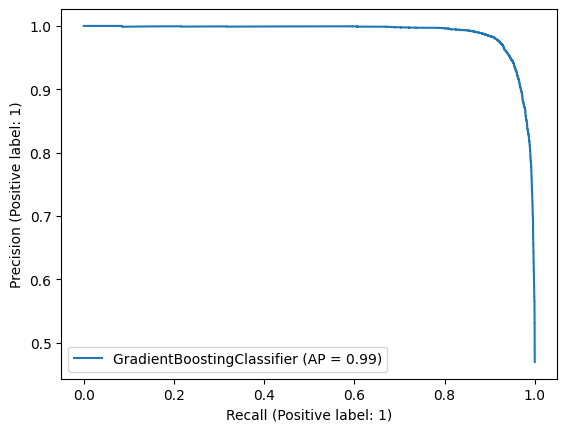

(None, {'df_train':                                                     title   
0       Objective-Dependent Uncertainty Driven Retinal...  \
1       SMARTies: Sentiment Models for Arabic Target E...   
2       State-Aware Tracker for Real-Time Video Object...   
3       On the Performance of Optimized Dense Device-t...   
4       Design of Minimum Correlated Maximal Clique Se...   
...                                                   ...   
124995  Domain Adaptation for Ear Recognition Using De...   
124996                      DeepHashing using TripletLoss   
124997  Appearance Based Deep Domain Adaptation for th...   
124998  The Importance of Automatic Syntactic Features...   
124999  Promising Accurate Prefix Boosting for sequenc...   

                                                 abstract  InformationTheory   
0         From diagnosing neovascular diseases to dete...                  0  \
1         We consider entity-level sentiment analysis ...                  0   
2      

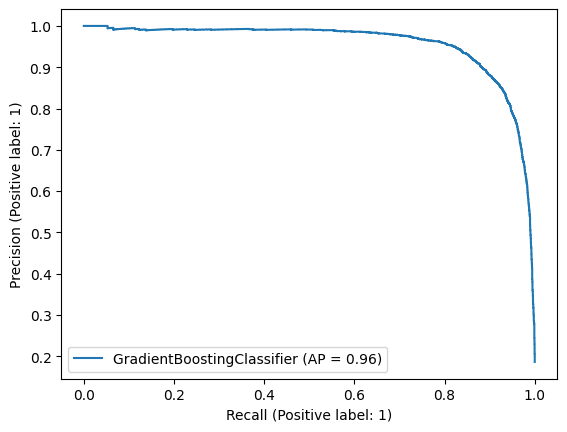

(None, {'df_train':                                                     title   
0       Objective-Dependent Uncertainty Driven Retinal...  \
1       SMARTies: Sentiment Models for Arabic Target E...   
2       State-Aware Tracker for Real-Time Video Object...   
3       On the Performance of Optimized Dense Device-t...   
4       Design of Minimum Correlated Maximal Clique Se...   
...                                                   ...   
124995  Domain Adaptation for Ear Recognition Using De...   
124996                      DeepHashing using TripletLoss   
124997  Appearance Based Deep Domain Adaptation for th...   
124998  The Importance of Automatic Syntactic Features...   
124999  Promising Accurate Prefix Boosting for sequenc...   

                                                 abstract  InformationTheory   
0         From diagnosing neovascular diseases to dete...                  0  \
1         We consider entity-level sentiment analysis ...                  0   
2      

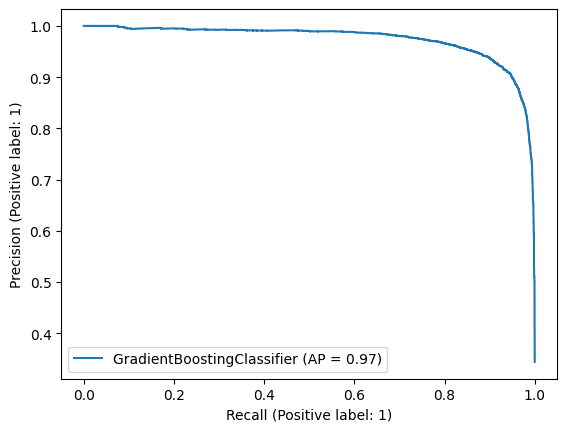

(None, {'df_train':                                                     title   
0       Objective-Dependent Uncertainty Driven Retinal...  \
1       SMARTies: Sentiment Models for Arabic Target E...   
2       State-Aware Tracker for Real-Time Video Object...   
3       On the Performance of Optimized Dense Device-t...   
4       Design of Minimum Correlated Maximal Clique Se...   
...                                                   ...   
124995  Domain Adaptation for Ear Recognition Using De...   
124996                      DeepHashing using TripletLoss   
124997  Appearance Based Deep Domain Adaptation for th...   
124998  The Importance of Automatic Syntactic Features...   
124999  Promising Accurate Prefix Boosting for sequenc...   

                                                 abstract  InformationTheory   
0         From diagnosing neovascular diseases to dete...                  0  \
1         We consider entity-level sentiment analysis ...                  0   
2      

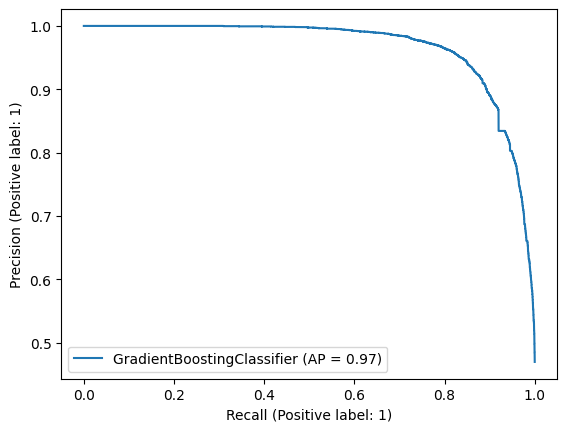

(None, {'df_train':                                                     title   
0       Objective-Dependent Uncertainty Driven Retinal...  \
1       SMARTies: Sentiment Models for Arabic Target E...   
2       State-Aware Tracker for Real-Time Video Object...   
3       On the Performance of Optimized Dense Device-t...   
4       Design of Minimum Correlated Maximal Clique Se...   
...                                                   ...   
124995  Domain Adaptation for Ear Recognition Using De...   
124996                      DeepHashing using TripletLoss   
124997  Appearance Based Deep Domain Adaptation for th...   
124998  The Importance of Automatic Syntactic Features...   
124999  Promising Accurate Prefix Boosting for sequenc...   

                                                 abstract  InformationTheory   
0         From diagnosing neovascular diseases to dete...                  0  \
1         We consider entity-level sentiment analysis ...                  0   
2      

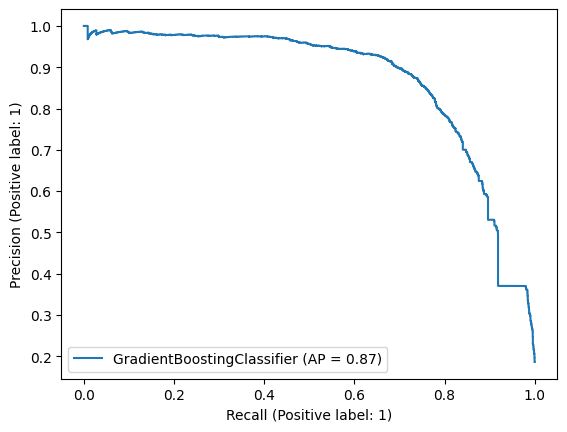

(None, {'df_train':                                                     title   
0       Objective-Dependent Uncertainty Driven Retinal...  \
1       SMARTies: Sentiment Models for Arabic Target E...   
2       State-Aware Tracker for Real-Time Video Object...   
3       On the Performance of Optimized Dense Device-t...   
4       Design of Minimum Correlated Maximal Clique Se...   
...                                                   ...   
124995  Domain Adaptation for Ear Recognition Using De...   
124996                      DeepHashing using TripletLoss   
124997  Appearance Based Deep Domain Adaptation for th...   
124998  The Importance of Automatic Syntactic Features...   
124999  Promising Accurate Prefix Boosting for sequenc...   

                                                 abstract  InformationTheory   
0         From diagnosing neovascular diseases to dete...                  0  \
1         We consider entity-level sentiment analysis ...                  0   
2      

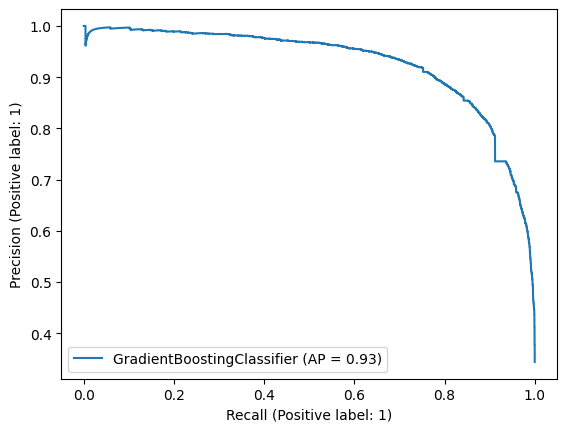

(None, {'df_train':                                                     title   
0       Objective-Dependent Uncertainty Driven Retinal...  \
1       SMARTies: Sentiment Models for Arabic Target E...   
2       State-Aware Tracker for Real-Time Video Object...   
3       On the Performance of Optimized Dense Device-t...   
4       Design of Minimum Correlated Maximal Clique Se...   
...                                                   ...   
124995  Domain Adaptation for Ear Recognition Using De...   
124996                      DeepHashing using TripletLoss   
124997  Appearance Based Deep Domain Adaptation for th...   
124998  The Importance of Automatic Syntactic Features...   
124999  Promising Accurate Prefix Boosting for sequenc...   

                                                 abstract  InformationTheory   
0         From diagnosing neovascular diseases to dete...                  0  \
1         We consider entity-level sentiment analysis ...                  0   
2      

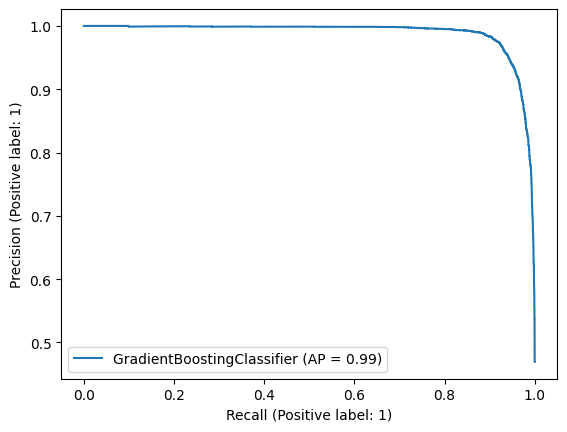

(None, {'df_train':                                                     title   
0       Objective-Dependent Uncertainty Driven Retinal...  \
1       SMARTies: Sentiment Models for Arabic Target E...   
2       State-Aware Tracker for Real-Time Video Object...   
3       On the Performance of Optimized Dense Device-t...   
4       Design of Minimum Correlated Maximal Clique Se...   
...                                                   ...   
124995  Domain Adaptation for Ear Recognition Using De...   
124996                      DeepHashing using TripletLoss   
124997  Appearance Based Deep Domain Adaptation for th...   
124998  The Importance of Automatic Syntactic Features...   
124999  Promising Accurate Prefix Boosting for sequenc...   

                                                 abstract  InformationTheory   
0         From diagnosing neovascular diseases to dete...                  0  \
1         We consider entity-level sentiment analysis ...                  0   
2      

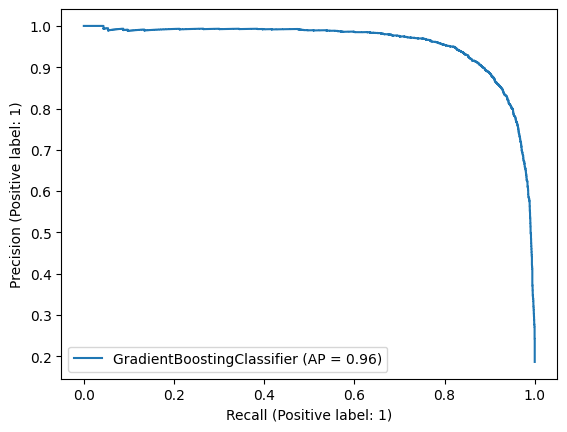

(None, {'df_train':                                                     title   
0       Objective-Dependent Uncertainty Driven Retinal...  \
1       SMARTies: Sentiment Models for Arabic Target E...   
2       State-Aware Tracker for Real-Time Video Object...   
3       On the Performance of Optimized Dense Device-t...   
4       Design of Minimum Correlated Maximal Clique Se...   
...                                                   ...   
124995  Domain Adaptation for Ear Recognition Using De...   
124996                      DeepHashing using TripletLoss   
124997  Appearance Based Deep Domain Adaptation for th...   
124998  The Importance of Automatic Syntactic Features...   
124999  Promising Accurate Prefix Boosting for sequenc...   

                                                 abstract  InformationTheory   
0         From diagnosing neovascular diseases to dete...                  0  \
1         We consider entity-level sentiment analysis ...                  0   
2      

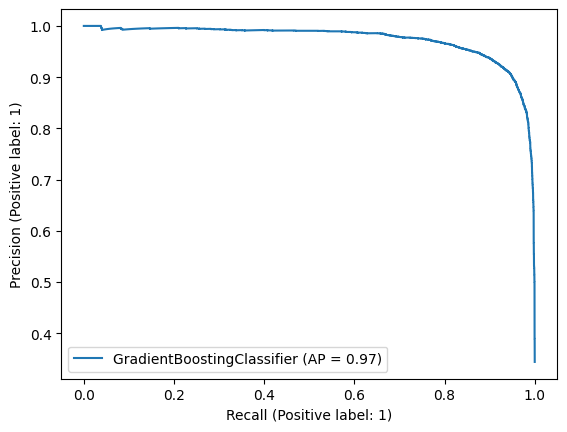

(None, {'df_train':                                                     title   
0       Objective-Dependent Uncertainty Driven Retinal...  \
1       SMARTies: Sentiment Models for Arabic Target E...   
2       State-Aware Tracker for Real-Time Video Object...   
3       On the Performance of Optimized Dense Device-t...   
4       Design of Minimum Correlated Maximal Clique Se...   
...                                                   ...   
124995  Domain Adaptation for Ear Recognition Using De...   
124996                      DeepHashing using TripletLoss   
124997  Appearance Based Deep Domain Adaptation for th...   
124998  The Importance of Automatic Syntactic Features...   
124999  Promising Accurate Prefix Boosting for sequenc...   

                                                 abstract  InformationTheory   
0         From diagnosing neovascular diseases to dete...                  0  \
1         We consider entity-level sentiment analysis ...                  0   
2      

In [ ]:
import combu
param_combinations = {
    'df_train': [df_train],
    'df_test':[df_test],
    'df_size': [1000, int(len(df_train))],
    'pp': ['1', '2'],
    'training_cols': ['title','abstract'],
    'classifying_cols': ['InformationTheory','ComputationalLinguistics','ComputerVision']
}

comb = combu.Combu(classifier_builder)

for output in comb.execute(param_combinations):
    print(output)

### Part 1B: RNN Method

The objective of developing RNN models here is to construct all 24 possible combinations and evaluate their accuracy, precision, recall, F1-score, and P-R curves. RNNs are commonly utilized for sequence analysis, where they accept a sequence of words one by one and generate a hidden state for each word. The RNN is applied recurrently by feeding in the current word and the previous word's hidden state to produce the subsequent hidden state. After obtaining the final hidden state, we pass it through a linear layer (fully connected layer) to get the predicted sentiment.

In [ ]:
import torch
import torchtext

In [ ]:
from torchtext.legacy.data import TabularDataset
from torchtext.legacy import data  

In [ ]:
#import spacy.cli
#spacy.cli.download("en_core_web_sm")
#nlp = spacy.load("en_core_web_sm")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 11.1 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
import spacy
en = spacy.load('en_core_web_sm')
stopwords = en.Defaults.stop_words

In [ ]:
stopwords = en.Defaults.stop_words
SEED = 1234
torch.manual_seed(SEED)

torch.backends.cudnn.deterministic = True

def RNN_PP(prepros):
    """
    Performs text pre-processing of documents.

    Parameters:
    ----------
    prepros: processing type to apply

    Returns:
    -------
    RNN_PP: preprocessed corpus

    """
    if prepros == 1:
        RNN_PP = data.Field(sequential=True, tokenize = 'spacy', lower=True, stop_words = set(stopwords))
    elif prepros == 2:
        RNN_PP = data.Field(sequential=True, tokenize = 'spacy', lower=False)
    else:
        print('invalid choice')
   
    return RNN_PP


In [ ]:
# code directly taken from week-4 tute (RNN_TextClassification)

import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        
        self.rnn = nn.RNN(embedding_dim, hidden_dim)
        
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text):

        #text = [sent len, batch size]
        
        embedded = self.embedding(text)
        
        #embedded = [sent len, batch size, emb dim]
        
        output, hidden = self.rnn(embedded)
        
        #output = [sent len, batch size, hid dim]
        #hidden = [1, batch size, hid dim]
        
        assert torch.equal(output[-1,:,:], hidden.squeeze(0))
        
        return self.fc(hidden.squeeze(0))

In [ ]:
# code directly taken from week-4 tute (RNN_TextClassification)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

#print(f'The model has {count_parameters(model):,} trainable parameters')

In [ ]:
# code directly taken from week-4 tute (RNN_TextClassification)

def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [ ]:
# code directly taken from week-4 tute (RNN_TextClassification)

def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        #######        
        predictions = model(batch.text).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
# code directly taken from week-4 tute (RNN_TextClassification)

def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:
            ##########
            predictions = model(batch.text).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
# code directly taken from week-4 tute (RNN_TextClassification)

import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:

import torch.optim as optim

def dataset_prep(df_train,df_test,df_size,pp, training_cols,classifying_cols):
    """
      Performs splitting the training data into training and validation data,
      applies text pre-processing on test data using the function created in the 
      previous step, optimising the parameters using SGD, fitting the model on training 
      data and predicting the values of our target label. Printing out the values 
      accuracy,precesion, recall, F-1 score, confusion matrix and the P-R curve
      Parameters:
      ----------
      df_train: training data
      df_test: test data
      df_size: size of training data-set
      pp: pre-processing
      training_cols: feature column
      classifying_cols: label column  
      Output:
      -------
      prints accuracy,precesion, recall, F-1 score, confusion matrix and the P-R curve.

    """
    if df_size == 1000:
        df_train = df_train.head(1000)
    else:
        df_train = df_train 
    
    train_size = int(0.9 * len(df_train)) 
    
    TEXT = RNN_PP(pp)
    LABEL = data.LabelField(dtype = torch.float, use_vocab=False, preprocessing=int)
    
    
    df_train_req_rr = df_train.iloc[:train_size]
    df_train_val_rr = df_train.iloc[train_size:] 
    
    # loading our datasets
    df_train_req_rr.to_csv(os.getcwd() + '/main_train.csv', index=False, columns=[training_cols, classifying_cols], header=['text', 'label'])
    df_train_val_rr.to_csv(os.getcwd() + '/main_val.csv', index=False, columns=[training_cols, classifying_cols], header=['text', 'label'])
    df_test.to_csv(os.getcwd() + '/main_test.csv', index=False, columns=[training_cols, classifying_cols], header=['text', 'label'])
    
    tv_datafields = [ ("text", TEXT),
                     ("label", LABEL)]
    
    train_data, valid_data, test_data = TabularDataset.splits(
    path=os.getcwd(), train='main_train.csv',
    validation='main_val.csv', test='main_test.csv', format='csv',skip_header=True,
    fields=tv_datafields)
    
    MAX_VOCAB_SIZE = 150000

    TEXT.build_vocab(train_data, max_size = MAX_VOCAB_SIZE)
    
    print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
    
    BATCH_SIZE = 8

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # creating batches for our training, validation and test datasets
    train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
        (train_data, valid_data, test_data), 
        batch_size = BATCH_SIZE,
        device = device,
        sort_key = lambda x: len(x.text),
        sort_within_batch = False)
    
    batch = next(train_iterator.__iter__())
    
    # hyper-parameters
    INPUT_DIM = len(TEXT.vocab)
    EMBEDDING_DIM = 50
    HIDDEN_DIM = 128
    
    OUTPUT_DIM = 1

    model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)
    
    print(f'The model has {count_parameters(model):,} trainable parameters')
    
    # optimising our parameters
    optimizer = optim.SGD(model.parameters(), lr=1e-3)
    # criterion to evaluate loss
    criterion = nn.BCEWithLogitsLoss()
    
    model = model.to(device)
    criterion = criterion.to(device)
    
    # number of epochs
    N_EPOCHS = 7

    best_valid_loss = float('inf')

    for epoch in range(N_EPOCHS):

        start_time = time.time()
    
        train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
        valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'RNN_model.pt')
    
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
        
    y_predict = []
    y_test = []
    y_sig = []

    model.eval()
    with torch.no_grad():
        for batch in test_iterator:
            predictions = model(batch.text).squeeze(1)
            rounded_preds = torch.round(torch.sigmoid(predictions))
            sig = torch.sigmoid(predictions)
            y_predict += rounded_preds.tolist()
            y_test += batch.label.tolist()
            y_sig += sig.tolist()
            
    y_predict = np.asarray(y_predict)
    y_test = np.asarray(y_test)
    y_sig = np.asarray(y_sig)
    print(confusion_matrix(y_test,y_predict))
    recall=recall_score(y_test,y_predict,average='macro')
    precision=precision_score(y_test,y_predict,average='macro')
    f1score=f1_score(y_test,y_predict,average='macro')
    accuracy=accuracy_score(y_test,y_predict)
    matthews = matthews_corrcoef(y_test,y_predict) 
    print('Accuracy: '+ str(accuracy))
    print('Macro Precision: '+ str(precision))
    print('Macro Recall: '+ str(recall))
    print('Macro F1 score:'+ str(f1score))
    #print('MCC:'+ str(matthews))
    
    p_r_curve = PrecisionRecallDisplay.from_predictions(y_test,y_sig)
    plt.show()

In [ ]:
pip install combu

Note: you may need to restart the kernel to use updated packages.


Unique tokens in TEXT vocabulary: 2531
The model has 149,719 trainable parameters
Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.644 | Train Acc: 68.81%
	 Val. Loss: 0.681 |  Val. Acc: 54.81%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.596 | Train Acc: 72.12%
	 Val. Loss: 0.674 |  Val. Acc: 55.77%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.590 | Train Acc: 71.68%
	 Val. Loss: 0.671 |  Val. Acc: 53.85%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.589 | Train Acc: 72.12%
	 Val. Loss: 0.669 |  Val. Acc: 56.73%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.585 | Train Acc: 72.68%
	 Val. Loss: 0.667 |  Val. Acc: 59.62%
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.584 | Train Acc: 72.35%
	 Val. Loss: 0.665 |  Val. Acc: 59.62%
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.587 | Train Acc: 72.57%
	 Val. Loss: 0.662 |  Val. Acc: 59.62%
[[7340 2247]
 [6317 2162]]
Accuracy: 0.5259603675412377
Macro Precision: 0.5139069733168589
Macro Recall: 0.5103015047465761
Macro F1 score:0.4835333649307628


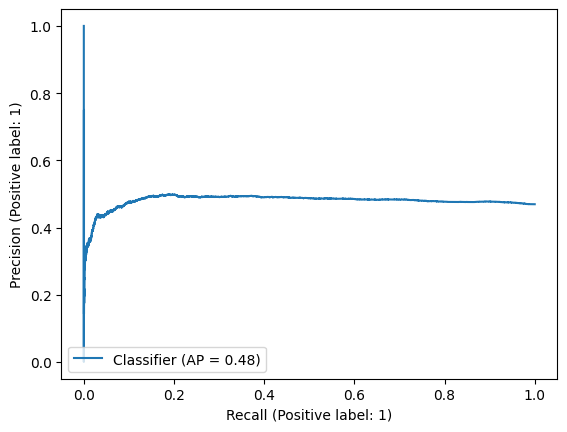

(None, {'df_train':                                                     title   
0       Objective-Dependent Uncertainty Driven Retinal...  \
1       SMARTies: Sentiment Models for Arabic Target E...   
2       State-Aware Tracker for Real-Time Video Object...   
3       On the Performance of Optimized Dense Device-t...   
4       Design of Minimum Correlated Maximal Clique Se...   
...                                                   ...   
124995  Domain Adaptation for Ear Recognition Using De...   
124996                      DeepHashing using TripletLoss   
124997  Appearance Based Deep Domain Adaptation for th...   
124998  The Importance of Automatic Syntactic Features...   
124999  Promising Accurate Prefix Boosting for sequenc...   

                                                 abstract  InformationTheory   
0         From diagnosing neovascular diseases to dete...                  0  \
1         We consider entity-level sentiment analysis ...                  0   
2      

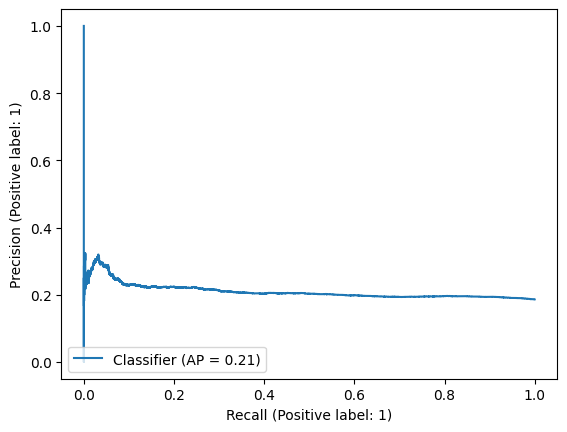

(None, {'df_train':                                                     title   
0       Objective-Dependent Uncertainty Driven Retinal...  \
1       SMARTies: Sentiment Models for Arabic Target E...   
2       State-Aware Tracker for Real-Time Video Object...   
3       On the Performance of Optimized Dense Device-t...   
4       Design of Minimum Correlated Maximal Clique Se...   
...                                                   ...   
124995  Domain Adaptation for Ear Recognition Using De...   
124996                      DeepHashing using TripletLoss   
124997  Appearance Based Deep Domain Adaptation for th...   
124998  The Importance of Automatic Syntactic Features...   
124999  Promising Accurate Prefix Boosting for sequenc...   

                                                 abstract  InformationTheory   
0         From diagnosing neovascular diseases to dete...                  0  \
1         We consider entity-level sentiment analysis ...                  0   
2      

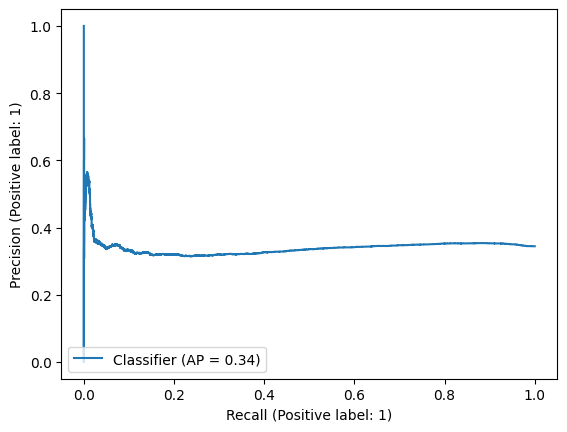

(None, {'df_train':                                                     title   
0       Objective-Dependent Uncertainty Driven Retinal...  \
1       SMARTies: Sentiment Models for Arabic Target E...   
2       State-Aware Tracker for Real-Time Video Object...   
3       On the Performance of Optimized Dense Device-t...   
4       Design of Minimum Correlated Maximal Clique Se...   
...                                                   ...   
124995  Domain Adaptation for Ear Recognition Using De...   
124996                      DeepHashing using TripletLoss   
124997  Appearance Based Deep Domain Adaptation for th...   
124998  The Importance of Automatic Syntactic Features...   
124999  Promising Accurate Prefix Boosting for sequenc...   

                                                 abstract  InformationTheory   
0         From diagnosing neovascular diseases to dete...                  0  \
1         We consider entity-level sentiment analysis ...                  0   
2      

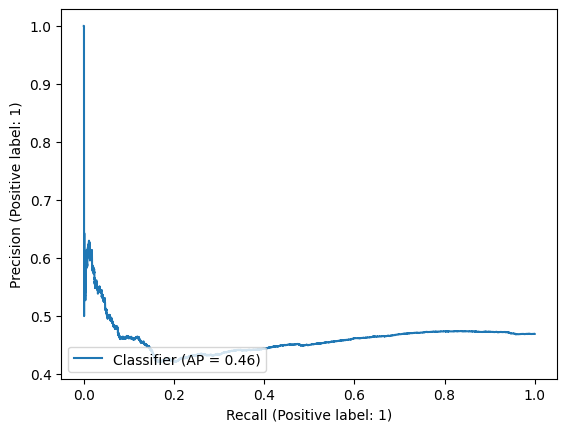

(None, {'df_train':                                                     title   
0       Objective-Dependent Uncertainty Driven Retinal...  \
1       SMARTies: Sentiment Models for Arabic Target E...   
2       State-Aware Tracker for Real-Time Video Object...   
3       On the Performance of Optimized Dense Device-t...   
4       Design of Minimum Correlated Maximal Clique Se...   
...                                                   ...   
124995  Domain Adaptation for Ear Recognition Using De...   
124996                      DeepHashing using TripletLoss   
124997  Appearance Based Deep Domain Adaptation for th...   
124998  The Importance of Automatic Syntactic Features...   
124999  Promising Accurate Prefix Boosting for sequenc...   

                                                 abstract  InformationTheory   
0         From diagnosing neovascular diseases to dete...                  0  \
1         We consider entity-level sentiment analysis ...                  0   
2      

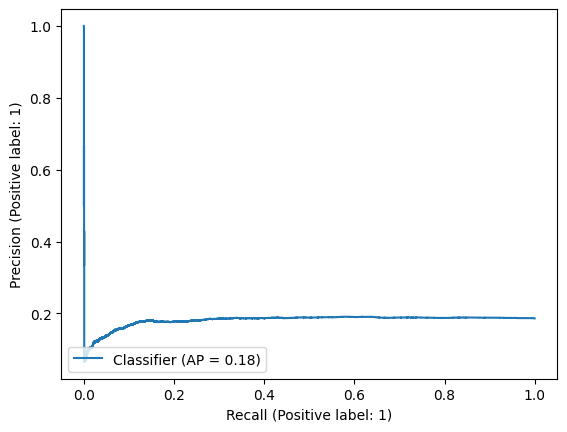

(None, {'df_train':                                                     title   
0       Objective-Dependent Uncertainty Driven Retinal...  \
1       SMARTies: Sentiment Models for Arabic Target E...   
2       State-Aware Tracker for Real-Time Video Object...   
3       On the Performance of Optimized Dense Device-t...   
4       Design of Minimum Correlated Maximal Clique Se...   
...                                                   ...   
124995  Domain Adaptation for Ear Recognition Using De...   
124996                      DeepHashing using TripletLoss   
124997  Appearance Based Deep Domain Adaptation for th...   
124998  The Importance of Automatic Syntactic Features...   
124999  Promising Accurate Prefix Boosting for sequenc...   

                                                 abstract  InformationTheory   
0         From diagnosing neovascular diseases to dete...                  0  \
1         We consider entity-level sentiment analysis ...                  0   
2      

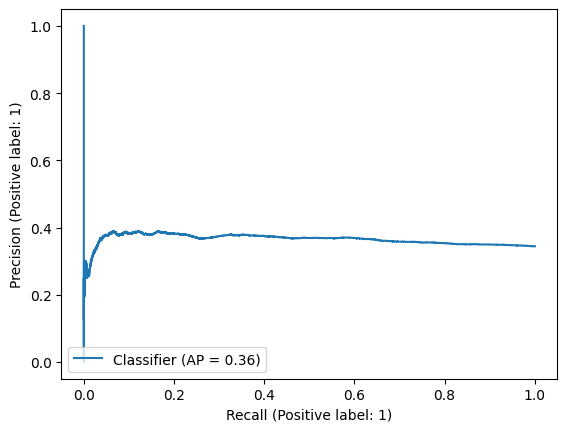

(None, {'df_train':                                                     title   
0       Objective-Dependent Uncertainty Driven Retinal...  \
1       SMARTies: Sentiment Models for Arabic Target E...   
2       State-Aware Tracker for Real-Time Video Object...   
3       On the Performance of Optimized Dense Device-t...   
4       Design of Minimum Correlated Maximal Clique Se...   
...                                                   ...   
124995  Domain Adaptation for Ear Recognition Using De...   
124996                      DeepHashing using TripletLoss   
124997  Appearance Based Deep Domain Adaptation for th...   
124998  The Importance of Automatic Syntactic Features...   
124999  Promising Accurate Prefix Boosting for sequenc...   

                                                 abstract  InformationTheory   
0         From diagnosing neovascular diseases to dete...                  0  \
1         We consider entity-level sentiment analysis ...                  0   
2      

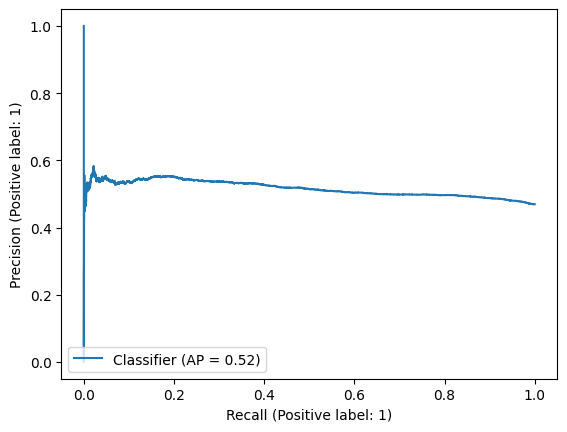

(None, {'df_train':                                                     title   
0       Objective-Dependent Uncertainty Driven Retinal...  \
1       SMARTies: Sentiment Models for Arabic Target E...   
2       State-Aware Tracker for Real-Time Video Object...   
3       On the Performance of Optimized Dense Device-t...   
4       Design of Minimum Correlated Maximal Clique Se...   
...                                                   ...   
124995  Domain Adaptation for Ear Recognition Using De...   
124996                      DeepHashing using TripletLoss   
124997  Appearance Based Deep Domain Adaptation for th...   
124998  The Importance of Automatic Syntactic Features...   
124999  Promising Accurate Prefix Boosting for sequenc...   

                                                 abstract  InformationTheory   
0         From diagnosing neovascular diseases to dete...                  0  \
1         We consider entity-level sentiment analysis ...                  0   
2      

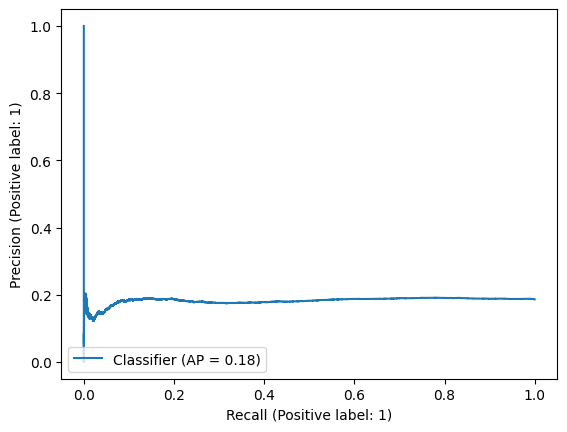

(None, {'df_train':                                                     title   
0       Objective-Dependent Uncertainty Driven Retinal...  \
1       SMARTies: Sentiment Models for Arabic Target E...   
2       State-Aware Tracker for Real-Time Video Object...   
3       On the Performance of Optimized Dense Device-t...   
4       Design of Minimum Correlated Maximal Clique Se...   
...                                                   ...   
124995  Domain Adaptation for Ear Recognition Using De...   
124996                      DeepHashing using TripletLoss   
124997  Appearance Based Deep Domain Adaptation for th...   
124998  The Importance of Automatic Syntactic Features...   
124999  Promising Accurate Prefix Boosting for sequenc...   

                                                 abstract  InformationTheory   
0         From diagnosing neovascular diseases to dete...                  0  \
1         We consider entity-level sentiment analysis ...                  0   
2      

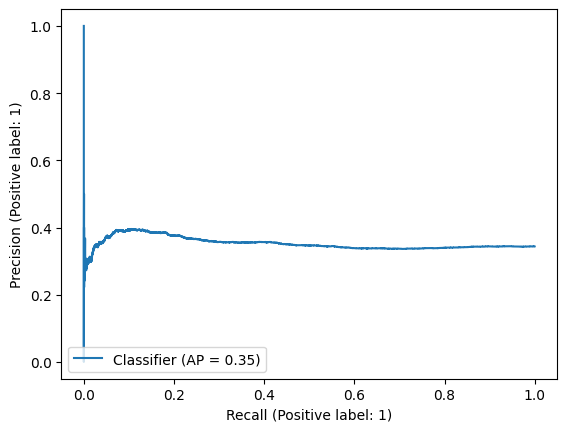

(None, {'df_train':                                                     title   
0       Objective-Dependent Uncertainty Driven Retinal...  \
1       SMARTies: Sentiment Models for Arabic Target E...   
2       State-Aware Tracker for Real-Time Video Object...   
3       On the Performance of Optimized Dense Device-t...   
4       Design of Minimum Correlated Maximal Clique Se...   
...                                                   ...   
124995  Domain Adaptation for Ear Recognition Using De...   
124996                      DeepHashing using TripletLoss   
124997  Appearance Based Deep Domain Adaptation for th...   
124998  The Importance of Automatic Syntactic Features...   
124999  Promising Accurate Prefix Boosting for sequenc...   

                                                 abstract  InformationTheory   
0         From diagnosing neovascular diseases to dete...                  0  \
1         We consider entity-level sentiment analysis ...                  0   
2      

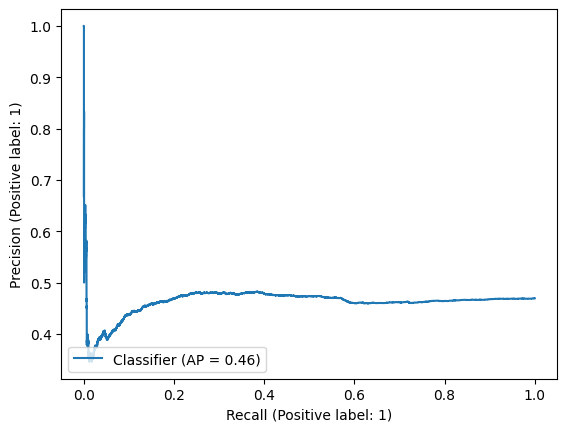

(None, {'df_train':                                                     title   
0       Objective-Dependent Uncertainty Driven Retinal...  \
1       SMARTies: Sentiment Models for Arabic Target E...   
2       State-Aware Tracker for Real-Time Video Object...   
3       On the Performance of Optimized Dense Device-t...   
4       Design of Minimum Correlated Maximal Clique Se...   
...                                                   ...   
124995  Domain Adaptation for Ear Recognition Using De...   
124996                      DeepHashing using TripletLoss   
124997  Appearance Based Deep Domain Adaptation for th...   
124998  The Importance of Automatic Syntactic Features...   
124999  Promising Accurate Prefix Boosting for sequenc...   

                                                 abstract  InformationTheory   
0         From diagnosing neovascular diseases to dete...                  0  \
1         We consider entity-level sentiment analysis ...                  0   
2      

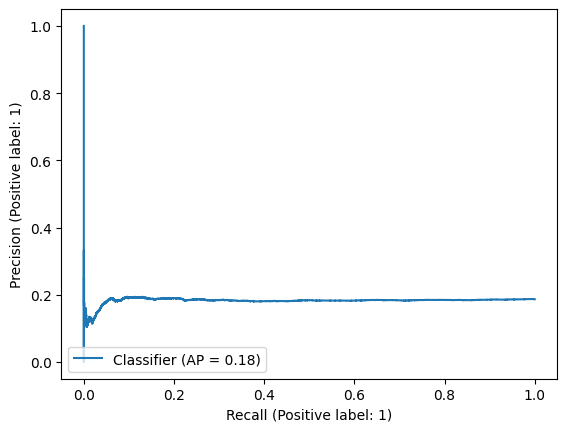

(None, {'df_train':                                                     title   
0       Objective-Dependent Uncertainty Driven Retinal...  \
1       SMARTies: Sentiment Models for Arabic Target E...   
2       State-Aware Tracker for Real-Time Video Object...   
3       On the Performance of Optimized Dense Device-t...   
4       Design of Minimum Correlated Maximal Clique Se...   
...                                                   ...   
124995  Domain Adaptation for Ear Recognition Using De...   
124996                      DeepHashing using TripletLoss   
124997  Appearance Based Deep Domain Adaptation for th...   
124998  The Importance of Automatic Syntactic Features...   
124999  Promising Accurate Prefix Boosting for sequenc...   

                                                 abstract  InformationTheory   
0         From diagnosing neovascular diseases to dete...                  0  \
1         We consider entity-level sentiment analysis ...                  0   
2      

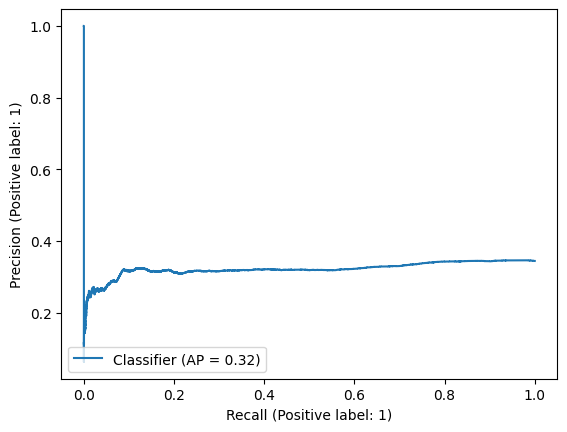

(None, {'df_train':                                                     title   
0       Objective-Dependent Uncertainty Driven Retinal...  \
1       SMARTies: Sentiment Models for Arabic Target E...   
2       State-Aware Tracker for Real-Time Video Object...   
3       On the Performance of Optimized Dense Device-t...   
4       Design of Minimum Correlated Maximal Clique Se...   
...                                                   ...   
124995  Domain Adaptation for Ear Recognition Using De...   
124996                      DeepHashing using TripletLoss   
124997  Appearance Based Deep Domain Adaptation for th...   
124998  The Importance of Automatic Syntactic Features...   
124999  Promising Accurate Prefix Boosting for sequenc...   

                                                 abstract  InformationTheory   
0         From diagnosing neovascular diseases to dete...                  0  \
1         We consider entity-level sentiment analysis ...                  0   
2      

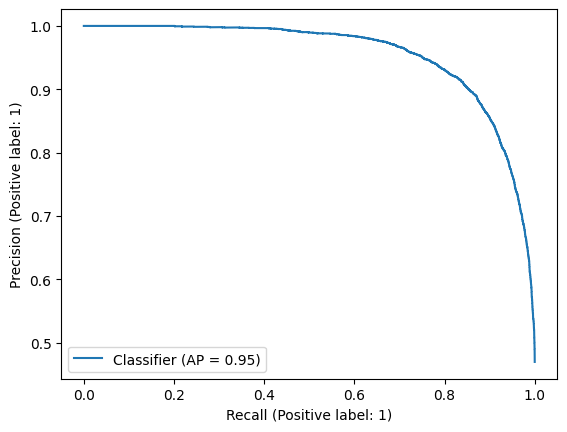

(None, {'df_train':                                                     title   
0       Objective-Dependent Uncertainty Driven Retinal...  \
1       SMARTies: Sentiment Models for Arabic Target E...   
2       State-Aware Tracker for Real-Time Video Object...   
3       On the Performance of Optimized Dense Device-t...   
4       Design of Minimum Correlated Maximal Clique Se...   
...                                                   ...   
124995  Domain Adaptation for Ear Recognition Using De...   
124996                      DeepHashing using TripletLoss   
124997  Appearance Based Deep Domain Adaptation for th...   
124998  The Importance of Automatic Syntactic Features...   
124999  Promising Accurate Prefix Boosting for sequenc...   

                                                 abstract  InformationTheory   
0         From diagnosing neovascular diseases to dete...                  0  \
1         We consider entity-level sentiment analysis ...                  0   
2      

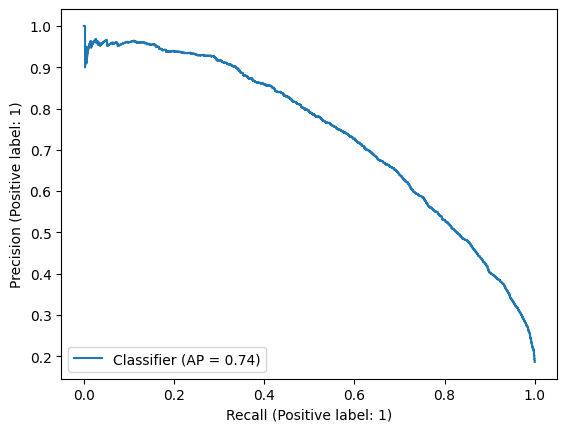

(None, {'df_train':                                                     title   
0       Objective-Dependent Uncertainty Driven Retinal...  \
1       SMARTies: Sentiment Models for Arabic Target E...   
2       State-Aware Tracker for Real-Time Video Object...   
3       On the Performance of Optimized Dense Device-t...   
4       Design of Minimum Correlated Maximal Clique Se...   
...                                                   ...   
124995  Domain Adaptation for Ear Recognition Using De...   
124996                      DeepHashing using TripletLoss   
124997  Appearance Based Deep Domain Adaptation for th...   
124998  The Importance of Automatic Syntactic Features...   
124999  Promising Accurate Prefix Boosting for sequenc...   

                                                 abstract  InformationTheory   
0         From diagnosing neovascular diseases to dete...                  0  \
1         We consider entity-level sentiment analysis ...                  0   
2      

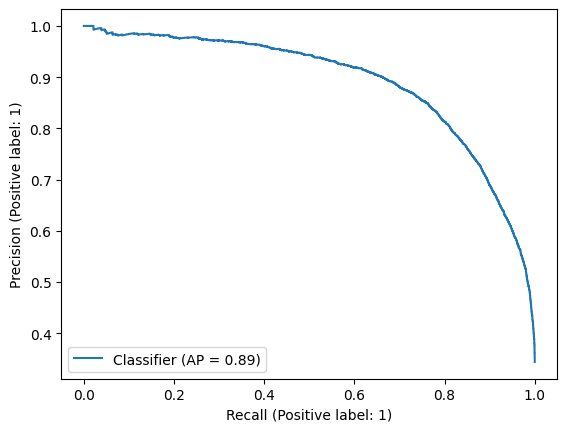

(None, {'df_train':                                                     title   
0       Objective-Dependent Uncertainty Driven Retinal...  \
1       SMARTies: Sentiment Models for Arabic Target E...   
2       State-Aware Tracker for Real-Time Video Object...   
3       On the Performance of Optimized Dense Device-t...   
4       Design of Minimum Correlated Maximal Clique Se...   
...                                                   ...   
124995  Domain Adaptation for Ear Recognition Using De...   
124996                      DeepHashing using TripletLoss   
124997  Appearance Based Deep Domain Adaptation for th...   
124998  The Importance of Automatic Syntactic Features...   
124999  Promising Accurate Prefix Boosting for sequenc...   

                                                 abstract  InformationTheory   
0         From diagnosing neovascular diseases to dete...                  0  \
1         We consider entity-level sentiment analysis ...                  0   
2      

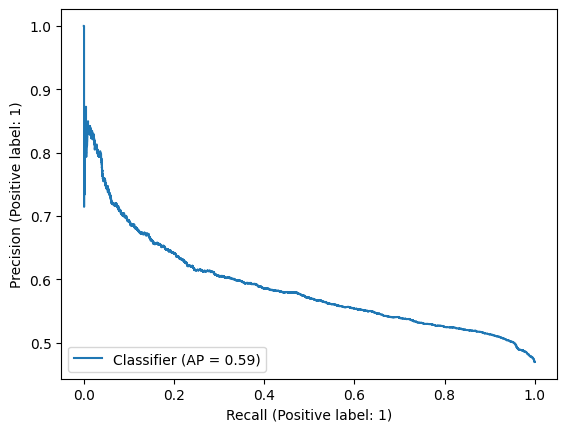

(None, {'df_train':                                                     title   
0       Objective-Dependent Uncertainty Driven Retinal...  \
1       SMARTies: Sentiment Models for Arabic Target E...   
2       State-Aware Tracker for Real-Time Video Object...   
3       On the Performance of Optimized Dense Device-t...   
4       Design of Minimum Correlated Maximal Clique Se...   
...                                                   ...   
124995  Domain Adaptation for Ear Recognition Using De...   
124996                      DeepHashing using TripletLoss   
124997  Appearance Based Deep Domain Adaptation for th...   
124998  The Importance of Automatic Syntactic Features...   
124999  Promising Accurate Prefix Boosting for sequenc...   

                                                 abstract  InformationTheory   
0         From diagnosing neovascular diseases to dete...                  0  \
1         We consider entity-level sentiment analysis ...                  0   
2      

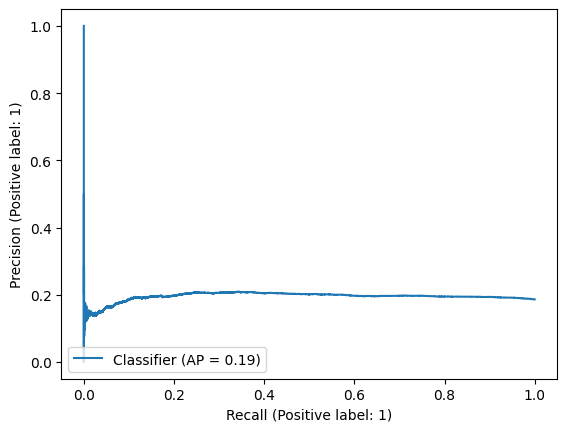

(None, {'df_train':                                                     title   
0       Objective-Dependent Uncertainty Driven Retinal...  \
1       SMARTies: Sentiment Models for Arabic Target E...   
2       State-Aware Tracker for Real-Time Video Object...   
3       On the Performance of Optimized Dense Device-t...   
4       Design of Minimum Correlated Maximal Clique Se...   
...                                                   ...   
124995  Domain Adaptation for Ear Recognition Using De...   
124996                      DeepHashing using TripletLoss   
124997  Appearance Based Deep Domain Adaptation for th...   
124998  The Importance of Automatic Syntactic Features...   
124999  Promising Accurate Prefix Boosting for sequenc...   

                                                 abstract  InformationTheory   
0         From diagnosing neovascular diseases to dete...                  0  \
1         We consider entity-level sentiment analysis ...                  0   
2      

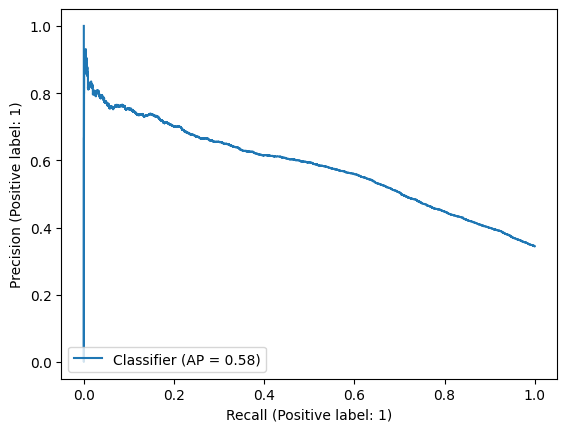

(None, {'df_train':                                                     title   
0       Objective-Dependent Uncertainty Driven Retinal...  \
1       SMARTies: Sentiment Models for Arabic Target E...   
2       State-Aware Tracker for Real-Time Video Object...   
3       On the Performance of Optimized Dense Device-t...   
4       Design of Minimum Correlated Maximal Clique Se...   
...                                                   ...   
124995  Domain Adaptation for Ear Recognition Using De...   
124996                      DeepHashing using TripletLoss   
124997  Appearance Based Deep Domain Adaptation for th...   
124998  The Importance of Automatic Syntactic Features...   
124999  Promising Accurate Prefix Boosting for sequenc...   

                                                 abstract  InformationTheory   
0         From diagnosing neovascular diseases to dete...                  0  \
1         We consider entity-level sentiment analysis ...                  0   
2      

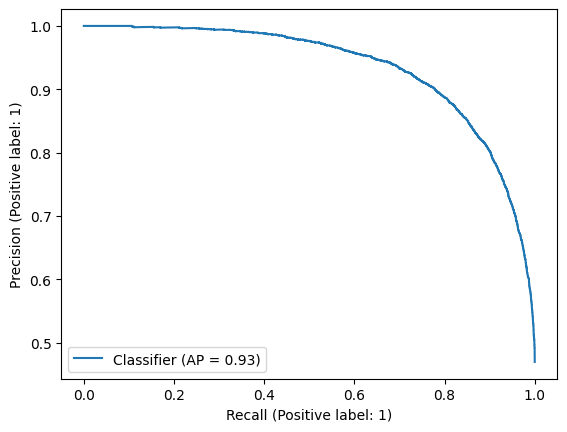

(None, {'df_train':                                                     title   
0       Objective-Dependent Uncertainty Driven Retinal...  \
1       SMARTies: Sentiment Models for Arabic Target E...   
2       State-Aware Tracker for Real-Time Video Object...   
3       On the Performance of Optimized Dense Device-t...   
4       Design of Minimum Correlated Maximal Clique Se...   
...                                                   ...   
124995  Domain Adaptation for Ear Recognition Using De...   
124996                      DeepHashing using TripletLoss   
124997  Appearance Based Deep Domain Adaptation for th...   
124998  The Importance of Automatic Syntactic Features...   
124999  Promising Accurate Prefix Boosting for sequenc...   

                                                 abstract  InformationTheory   
0         From diagnosing neovascular diseases to dete...                  0  \
1         We consider entity-level sentiment analysis ...                  0   
2      

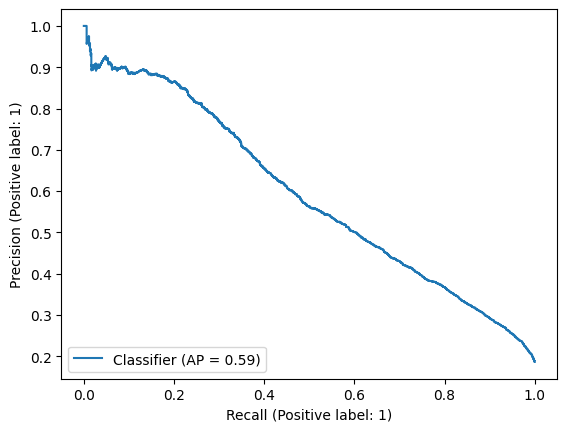

(None, {'df_train':                                                     title   
0       Objective-Dependent Uncertainty Driven Retinal...  \
1       SMARTies: Sentiment Models for Arabic Target E...   
2       State-Aware Tracker for Real-Time Video Object...   
3       On the Performance of Optimized Dense Device-t...   
4       Design of Minimum Correlated Maximal Clique Se...   
...                                                   ...   
124995  Domain Adaptation for Ear Recognition Using De...   
124996                      DeepHashing using TripletLoss   
124997  Appearance Based Deep Domain Adaptation for th...   
124998  The Importance of Automatic Syntactic Features...   
124999  Promising Accurate Prefix Boosting for sequenc...   

                                                 abstract  InformationTheory   
0         From diagnosing neovascular diseases to dete...                  0  \
1         We consider entity-level sentiment analysis ...                  0   
2      

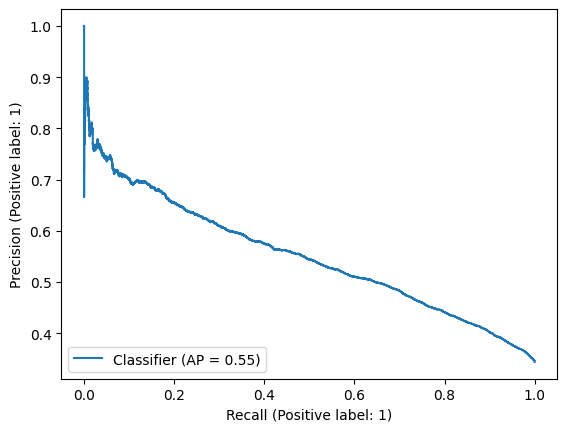

(None, {'df_train':                                                     title   
0       Objective-Dependent Uncertainty Driven Retinal...  \
1       SMARTies: Sentiment Models for Arabic Target E...   
2       State-Aware Tracker for Real-Time Video Object...   
3       On the Performance of Optimized Dense Device-t...   
4       Design of Minimum Correlated Maximal Clique Se...   
...                                                   ...   
124995  Domain Adaptation for Ear Recognition Using De...   
124996                      DeepHashing using TripletLoss   
124997  Appearance Based Deep Domain Adaptation for th...   
124998  The Importance of Automatic Syntactic Features...   
124999  Promising Accurate Prefix Boosting for sequenc...   

                                                 abstract  InformationTheory   
0         From diagnosing neovascular diseases to dete...                  0  \
1         We consider entity-level sentiment analysis ...                  0   
2      

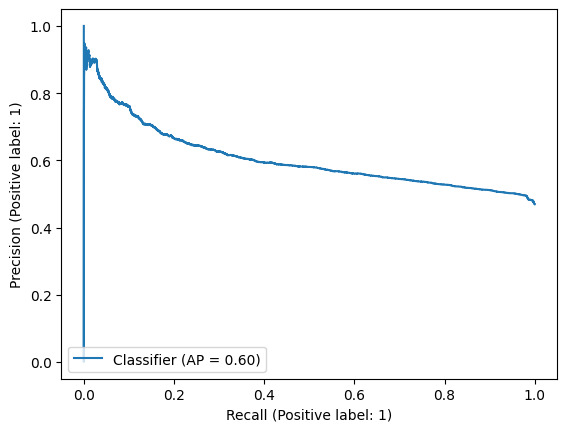

(None, {'df_train':                                                     title   
0       Objective-Dependent Uncertainty Driven Retinal...  \
1       SMARTies: Sentiment Models for Arabic Target E...   
2       State-Aware Tracker for Real-Time Video Object...   
3       On the Performance of Optimized Dense Device-t...   
4       Design of Minimum Correlated Maximal Clique Se...   
...                                                   ...   
124995  Domain Adaptation for Ear Recognition Using De...   
124996                      DeepHashing using TripletLoss   
124997  Appearance Based Deep Domain Adaptation for th...   
124998  The Importance of Automatic Syntactic Features...   
124999  Promising Accurate Prefix Boosting for sequenc...   

                                                 abstract  InformationTheory   
0         From diagnosing neovascular diseases to dete...                  0  \
1         We consider entity-level sentiment analysis ...                  0   
2      

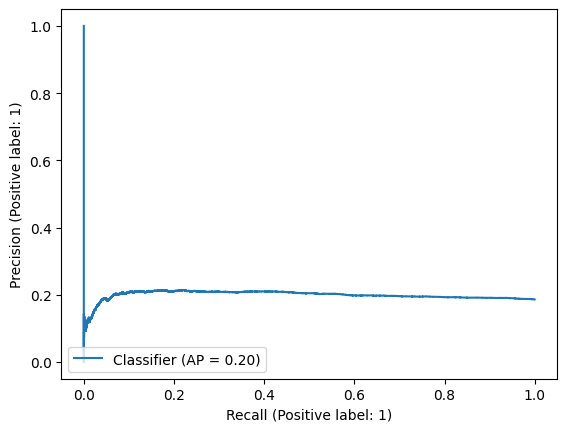

(None, {'df_train':                                                     title   
0       Objective-Dependent Uncertainty Driven Retinal...  \
1       SMARTies: Sentiment Models for Arabic Target E...   
2       State-Aware Tracker for Real-Time Video Object...   
3       On the Performance of Optimized Dense Device-t...   
4       Design of Minimum Correlated Maximal Clique Se...   
...                                                   ...   
124995  Domain Adaptation for Ear Recognition Using De...   
124996                      DeepHashing using TripletLoss   
124997  Appearance Based Deep Domain Adaptation for th...   
124998  The Importance of Automatic Syntactic Features...   
124999  Promising Accurate Prefix Boosting for sequenc...   

                                                 abstract  InformationTheory   
0         From diagnosing neovascular diseases to dete...                  0  \
1         We consider entity-level sentiment analysis ...                  0   
2      

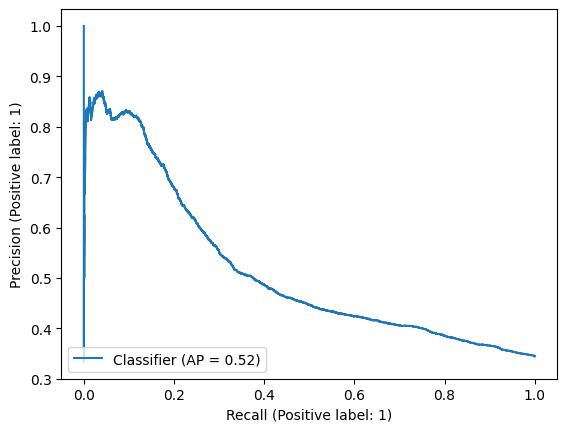

(None, {'df_train':                                                     title   
0       Objective-Dependent Uncertainty Driven Retinal...  \
1       SMARTies: Sentiment Models for Arabic Target E...   
2       State-Aware Tracker for Real-Time Video Object...   
3       On the Performance of Optimized Dense Device-t...   
4       Design of Minimum Correlated Maximal Clique Se...   
...                                                   ...   
124995  Domain Adaptation for Ear Recognition Using De...   
124996                      DeepHashing using TripletLoss   
124997  Appearance Based Deep Domain Adaptation for th...   
124998  The Importance of Automatic Syntactic Features...   
124999  Promising Accurate Prefix Boosting for sequenc...   

                                                 abstract  InformationTheory   
0         From diagnosing neovascular diseases to dete...                  0  \
1         We consider entity-level sentiment analysis ...                  0   
2      

In [ ]:
import combu

param_combinations2 = {
    'df_train': [df_train],
    'df_test':[df_test],
    'df_size': [1000, int(len(df_train))],
    'pp': [1, 2],
    'training_cols': ['title','abstract'],
    'classifying_cols': ['InformationTheory','ComputationalLinguistics','ComputerVision']
}


comb_rnn = combu.Combu(dataset_prep)

for output in comb_rnn.execute(param_combinations2):
    print(output)